In [1]:
import os
import matplotlib
from math import *
from pandas import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
# sns.set(style="darkgrid")

In [2]:
pcap_file ="../firefox03/firefox03.raw"
csv_file = "../firefox03/firefox03.csv"
if not os.path.exists(csv_file):
    tshark_cmd = 'tshark -T fields -e _ws.col.No. -e _ws.col.Time -e _ws.col.Source -e _ws.col.Destination -e _ws.col.tls_len -e _ws.col.Info -E header=y -E separator="\t" -E quote=d -E occurrence=f -r {} > {}'.format(pcap_file, csv_file)  
    os.system(tshark_cmd)

In [3]:
pcap_main = read_csv(csv_file,sep="\t", index_col=None, encoding='utf-8')
pcap_main.rename(index=str, columns={"_ws.col.No.": "No", "_ws.col.Time": "Time","_ws.col.Source": "Source","_ws.col.Destination": "Destination", "_ws.col.tls_len": "tls_len","_ws.col.Info": "Info"}, inplace=True);
pcap_main.head()

,No,Time,Source,Destination,tls_len,Info
0,1,0.000000,10.6.0.11,192.168.1.238,NaN,Standard query response 0x4a36 A snippets.cdn....
1,2,0.000335,192.168.1.238,13.249.218.60,NaN,54816 → 443 [SYN] Seq=0 Win=29200 Len=0 MSS=14...
2,3,0.018361,192.168.1.238,10.6.0.11,NaN,Standard query 0xbece A push.services.mozilla.com
3,4,0.018981,13.249.218.60,192.168.1.238,NaN,"443 → 54816 [SYN, ACK] Seq=0 Ack=1 Win=28960 L..."
4,5,0.019006,192.168.1.238,13.249.218.60,NaN,54816 → 443 [ACK] Seq=1 Ack=1 Win=29312 Len=0 ...


In [4]:
pcap_main.shape

(719865, 6)

In [5]:
local_ip = pcap_main['Destination'].value_counts().idxmax()
nf_ip = pcap_main['Source'].value_counts().idxmax()

In [6]:
print(local_ip,nf_ip)

192.168.1.238 45.57.51.132


In [7]:
# Create new data frame to plot the get requests
pcap_get = pcap_main[pcap_main['Destination']== nf_ip]

In [8]:
pcap_get.shape

(283093, 6)

In [9]:
pcap_get.head()

,No,Time,Source,Destination,tls_len,Info
21652,21653,29.789272,192.168.1.238,45.57.51.132,NaN,51246 → 443 [SYN] Seq=0 Win=29200 Len=0 MSS=14...
21660,21661,29.841187,192.168.1.238,45.57.51.132,NaN,51246 → 443 [ACK] Seq=1 Ack=1 Win=29312 Len=0 ...
21671,21672,29.843262,192.168.1.238,45.57.51.132,512,Client Hello
21684,21685,29.891190,192.168.1.238,45.57.51.132,NaN,51246 → 443 [ACK] Seq=518 Ack=1449 Win=32128 L...
21686,21687,29.891422,192.168.1.238,45.57.51.132,NaN,51246 → 443 [ACK] Seq=518 Ack=3211 Win=35712 L...


In [10]:
pcap_get = pcap_get.dropna(subset=['tls_len'])

In [11]:
pcap_get.shape

(3771, 6)

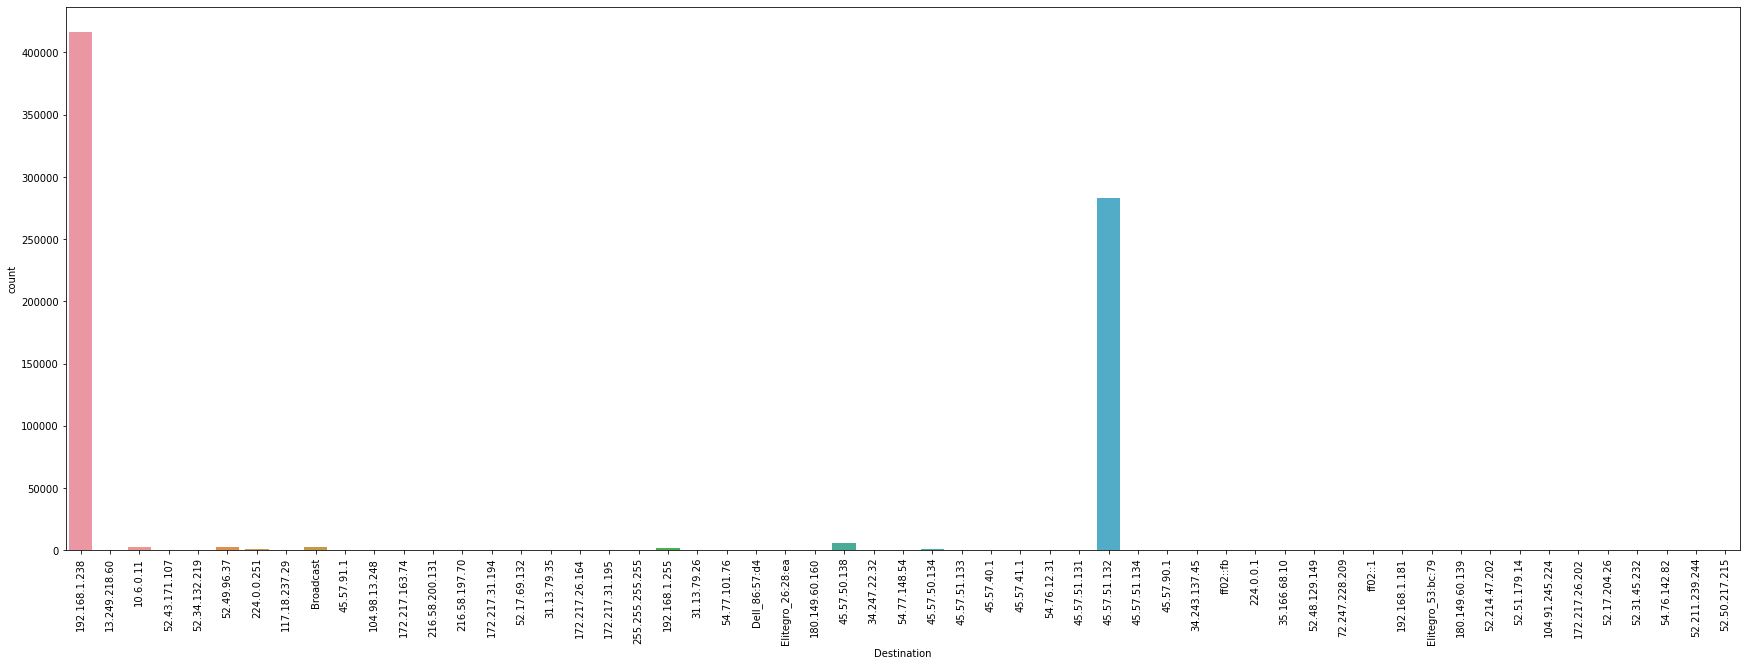

In [12]:
# request per ip plot 
plt.figure(figsize=(30 ,10))
ax = sns.countplot(x="Destination", data=pcap_main)
plt.xticks(rotation=90)
plt.rcParams['xtick.labelsize'] = 15

In [13]:
# countng number of packets arived at a particular time (sec)
pkt_cnt = [0] # number of Packets at i'th sec 
d_time = []  # list of time 
start_time = floor(pcap_get.iloc[0,1]) # start time of the first packet in the list

i = 0
d_time.append(start_time)

for _,packet in pcap_get.iterrows():
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        pkt_cnt.append(0)
        d_time.append(curr_time)
        start_time = curr_time
    pkt_cnt[i]+= 1
    

In [31]:
# plotting number of packets vs time
# fig, ax = plt.subplots(1, 1, figsize = (30, 15), dpi=300)
# ax = sns.barplot(d_time, pkt_cnt)
# plt.ylabel('No of packerts exchanged')
# plt.xlabel('time in sec')
# plt.title("packet_count vs time")
# ax.set(xticks=[]);

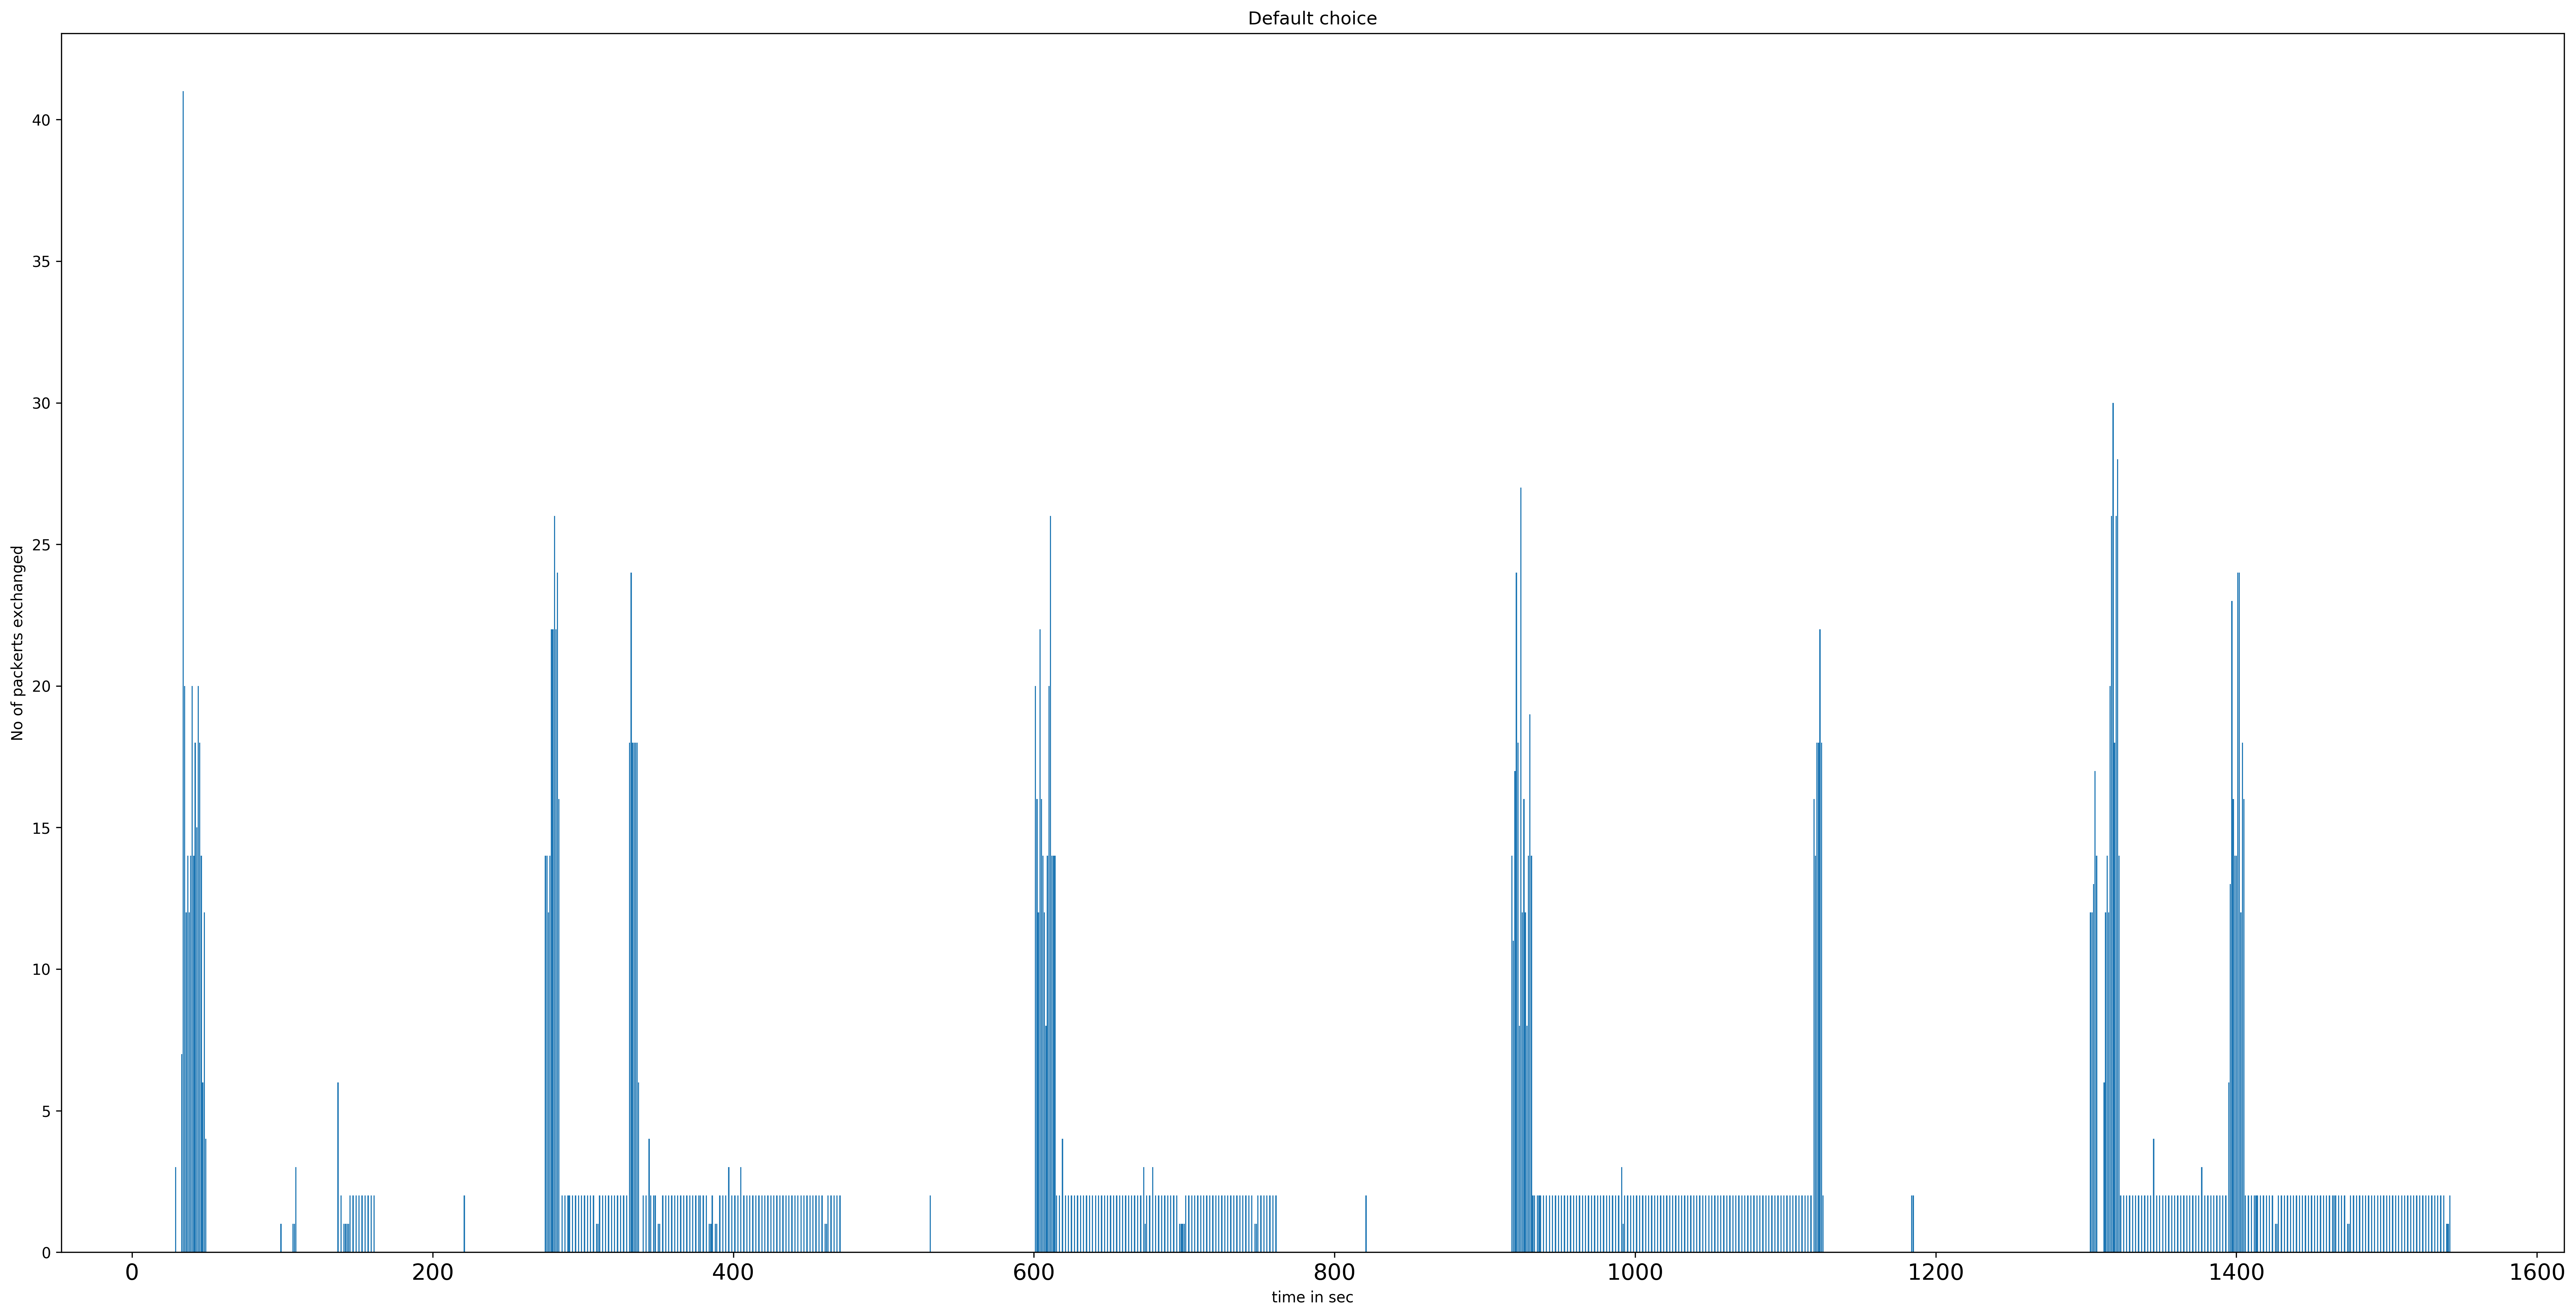

In [32]:
# plotting number of packets vs time
fig, ax = plt.subplots(1, 1, figsize = (30, 15), dpi=300)
plt.bar(d_time[:500], pkt_cnt[:500])
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.show()

In [16]:
temp = list(zip(pkt_cnt, d_time))
temp[:11]

[(3, 29),
 (7, 33),
 (41, 34),
 (20, 35),
 (12, 36),
 (14, 37),
 (12, 38),
 (14, 39),
 (20, 40),
 (14, 41),
 (18, 42)]

In [17]:
# Finding peaks
delta = 0
th = 8
peaks =[] # May contain duplicates
for i in range(1,len(pkt_cnt)):
    delta = pkt_cnt[i]-pkt_cnt[i-1]
    if delta > th:
        startTime = d_time[i]
    elif delta < -th:
        endTime = d_time[i]
        peaks.append([startTime, endTime])
print(peaks)

[[34, 35], [275, 286], [331, 337], [604, 612], [604, 615], [918, 923], [924, 925], [924, 932], [1119, 1125], [1303, 1319], [1303, 1322], [1303, 1323], [1401, 1403], [1401, 1406], [1603, 1610], [1882, 1949], [1967, 1976], [2002, 2005], [2002, 2006], [2124, 2132], [2124, 2136]]


In [18]:
# range with no duplicates
f_peaks = [] # Final peaks with hopefuly no duplicates
for i in range(len(peaks)-1):
    if peaks[i][0] != peaks[i+1][0]:
        f_peaks.append(peaks[i])
f_peaks.append(peaks[i+1])

print(f_peaks)

[[34, 35], [275, 286], [331, 337], [604, 615], [918, 923], [924, 932], [1119, 1125], [1303, 1323], [1401, 1406], [1603, 1610], [1882, 1949], [1967, 1976], [2002, 2006], [2124, 2136]]


In [19]:
# filling all unknown ssl.record.length with -1
pcap_main.fillna(-1, inplace=True)
pcap_main.head()

,No,Time,Source,Destination,tls_len,Info
0,1,0.000000,10.6.0.11,192.168.1.238,-1,Standard query response 0x4a36 A snippets.cdn....
1,2,0.000335,192.168.1.238,13.249.218.60,-1,54816 → 443 [SYN] Seq=0 Win=29200 Len=0 MSS=14...
2,3,0.018361,192.168.1.238,10.6.0.11,-1,Standard query 0xbece A push.services.mozilla.com
3,4,0.018981,13.249.218.60,192.168.1.238,-1,"443 → 54816 [SYN, ACK] Seq=0 Ack=1 Win=28960 L..."
4,5,0.019006,192.168.1.238,13.249.218.60,-1,54816 → 443 [ACK] Seq=1 Ack=1 Win=29312 Len=0 ...


In [20]:
# filtering out the non application data pakets
temp = pcap_main.query('Info == "Application Data"') # filtering to get only the application data
temp.shape

(12591, 6)

In [21]:
# converting the tls_len to integer type
temp['tls_len'] = temp.tls_len.astype(int, copy=False) # converting the ssllen field to integer type
# filtering to get ssllen in the 6000 to 7000 range.
# temp = temp.query('6000<ssllen<7000')
temp = temp.query('7000<tls_len<8500')


print(temp.shape)
temp.head()

(271, 6)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,No,Time,Source,Destination,tls_len,Info
2072,2073,5.230473,52.49.96.37,192.168.1.238,7709,Application Data
2108,2109,5.382837,52.49.96.37,192.168.1.238,8480,Application Data
3119,3120,9.877603,52.49.96.37,192.168.1.238,7007,Application Data
3473,3474,10.200602,192.168.1.238,52.49.96.37,7547,Application Data
3825,3826,13.272190,52.49.96.37,192.168.1.238,8119,Application Data


In [22]:
temp = temp.query('Source == "{}"'.format(local_ip)) # cl2 are sent from client system
print(temp.shape)
temp.head()

(17, 6)


,No,Time,Source,Destination,tls_len,Info
3473,3474,10.200602,192.168.1.238,52.49.96.37,7547,Application Data
5099,5100,15.160840,192.168.1.238,52.49.96.37,7887,Application Data
76575,76576,59.897918,192.168.1.238,35.166.68.10,8396,Application Data
77623,77624,130.265556,192.168.1.238,52.49.96.37,7483,Application Data
94542,94543,279.588110,192.168.1.238,52.49.96.37,7569,Application Data


In [23]:
# find all packets that looks like data-cl2
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = floor(temp.iloc[0,1])

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No'])
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['tls_len']/200
    
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

cl2 length: [37.735, 39.435, 41.98, 37.415, 37.845, 38.485, 38.735, 37.865, 36.475, 38.49, 37.83, 37.905, 37.935, 38.445, 40.865, 38.44, 38.505] 
cl2 occurance time: [10, 15, 59, 130, 279, 335, 605, 922, 987, 1124, 1307, 1399, 1607, 1963, 1970, 2000, 2129]


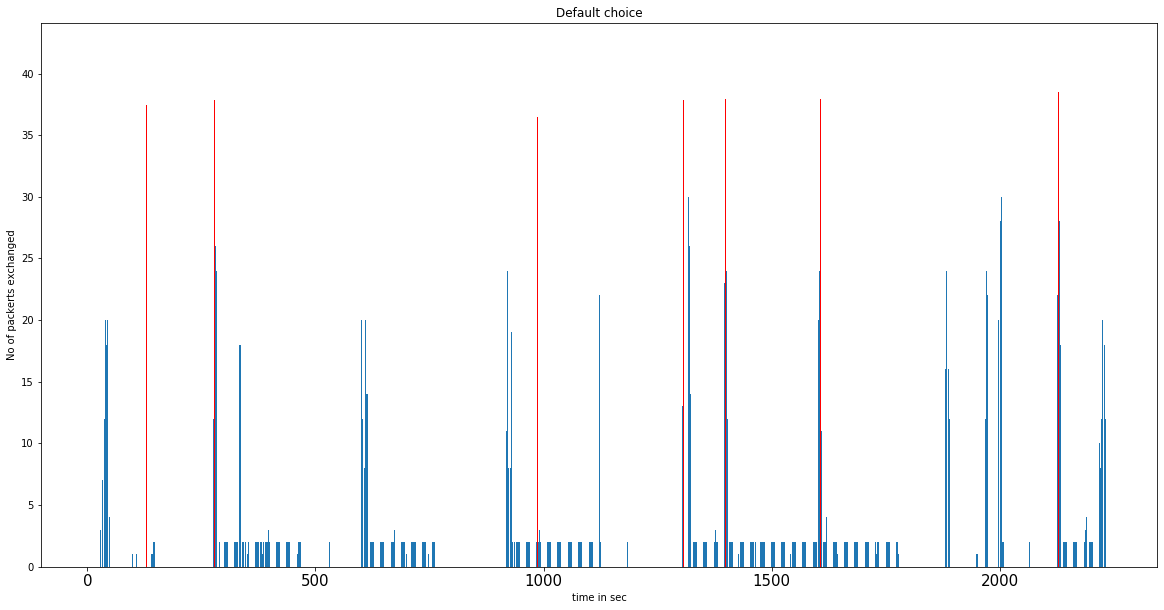

In [24]:
# plot the data-cl2 along with all the pakets
plt.figure(figsize=(20,10))
plt.bar(d_time, pkt_cnt)
plt.bar(cl2_time, cl2_cnt, color = 'red')
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.show()


In [25]:
# [{'time':x, 'frame_no':y } for x, y in zip(d,f_no)]

In [26]:
# filter out all the packets which are not near the peaks
final = []
for i in range(len(cl2_time)):
#     print("processing : {}".format(d[i]))
    for peak in f_peaks:
        if cl2_time[i]>= peak[0] and cl2_time[i]<=peak[-1]+2:
#             print("found in range : {}".format(peak))
            final.append(cl2_time[i])
#         else:
#             print("not found in any range") # debug

In [27]:
# comparing the filtered and non-filtered cl2's
print("using only length filter: {} \nfinal cl2's: {}".format(cl2_time, final))

using only length filter: [10, 15, 59, 130, 279, 335, 605, 922, 987, 1124, 1307, 1399, 1607, 1963, 1970, 2000, 2129] 
final cl2's: [279, 335, 605, 922, 1124, 1307, 1607, 1970, 2129]


In [28]:
# getting more details about the cl2's
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = temp.iloc[0,1]

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No'])
    curr_time = packet.Time
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['tls_len']
    
# printing the result
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

cl2 length: [7547, 7887, 8396, 7483, 7569, 7697, 7747, 7573, 7295, 7698, 7566, 7581, 7587, 7689, 8173, 7688, 7701] 
cl2 occurance time: [10.200601959, 15.160839532999999, 59.897917928000005, 130.265555502, 279.588110057, 335.741130799, 605.305658527, 922.0907583410001, 987.842028532, 1124.206673035, 1307.456674794, 1399.772334682, 1607.6722616289999, 1963.892354338, 1970.759306235, 2000.766497919, 2129.203950252]


In [29]:
ll = [[x,y] for x, y in zip(cl2_time,f_no)]
print(ll)

[[10.200601959, 3474], [15.160839532999999, 5100], [59.897917928000005, 76576], [130.265555502, 77624], [279.588110057, 94543], [335.741130799, 141011], [605.305658527, 185221], [922.0907583410001, 253707], [987.842028532, 298049], [1124.206673035, 341941], [1307.456674794, 355217], [1399.772334682, 422617], [1607.6722616289999, 499322], [1963.892354338, 569363], [1970.759306235, 577813], [2000.766497919, 602576], [2129.203950252, 640353]]


In [30]:
# filtering the cl2's if not near peak
final_cl2 = []
for l in ll:
#     print("processing : {}".format(l))
    for peak in f_peaks:
        if l[0]>= peak[0] and l[0]<=peak[-1]+2:
            final_cl2.append(l)
            
print(final_cl2)

[[279.588110057, 94543], [335.741130799, 141011], [605.305658527, 185221], [922.0907583410001, 253707], [1124.206673035, 341941], [1307.456674794, 355217], [1607.6722616289999, 499322], [1970.759306235, 577813], [2129.203950252, 640353]]
